In [1]:
%pip install -r requirements.txt 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 121.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 147.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.2/31.2 MB 50.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 2.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 139.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 152.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 159.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 28.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.3/214.3 kB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 136.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 944.1/944.1 kB 153.4 MB/s eta 0:00:00
     ━

In [8]:
import numpy as np
import datetime
import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [9]:
class StepbyStep(object):

    def __init__(self,model,loss_fn,optimizer):

        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)

        self.train_loader = None
        self.val_loader = None
        self.writer = None

        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        self.train_step = self._make_train_step()
        self.val_step = self._make_val_step()
    
    def to(self,device):

        self.device = device
        self.model.to(device)

    def set_loaders(self,train_loader,val_loader = None):
        
        self.train_loader = train_loader
        self.val_loader = val_loader
    
    def set_tensorboard(self,name,folder = 'runs'):

        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter('{}/{}/{}'.format(folder,name,suffix))
    
    def _make_train_step(self):

        def perform_train_step(x,y):

            self.model.train()

            yhat = self.model(x)
            loss = self.loss_fn(yhat,y)

            loss.backward()

            self.optimizer.step()
            self.optimizer.zero_grad()

            return loss.item()
        return perform_train_step
    
    def _make_val_step(self):

        def perform_val_step(x,y):

            self.model.eval()

            yhat = self.model(x)
            loss = self.loss_fn(yhat,y)

            return loss.item()
        return perform_val_step
    
    def _mini_batch(self,validation = False):
        
        if validation:
            data_loader = self.val_loader
            step = self.val_step
        else:
            data_loader = self.train_loader
            step = self.train_step
        
        if data_loader is None:
            return None
        
        mini_batch_losses = []
        for x_batch,y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step(x_batch,y_batch)
            mini_batch_losses.append(mini_batch_loss)
        
        loss = np.mean(mini_batch_losses)
        return loss
    
    def set_seed(self,seed = 42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    def train(self,n_epochs,seed=42):
        
        self.set_seed(seed)

        for epoch in range(n_epochs):

            self.total_epochs += 1

            loss = self._mini_batch(validation = False)
            self.losses.append(loss)

            with torch.no_grad():
                
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)
            
            if self.writer:
                scalars = {'training':loss}
                if val_loss is not None:
                    scalars.update({'validation':val_loss})
                
                self.writer.add_scalars(main_tag='loss',tag_scalar_dict=scalars,global_step = epoch)
            
        
        if self.writer:
            self.writer.flush()
        
    def save_checkpoint(self,filename):

            checkpoint = {
                'epoch' : self.total_epochs,
                'model_state_dict' : self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'loss' : self.losses,
                'val_loss': self.val_losses
            }

            torch.save(checkpoint,filename)
        
    def load_checkpoint(self,filename):

        checkpoint = torch.load(filename)

        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train()
    
    def predict(self,x):

        self.model.eval()

        x_tensor = torch.as_tensor(x).float()
        y_hat_tensor = self.model(x_tensor.to(self.device))

        self.model.train()

        return y_hat_tensor.detach().cpu().numpy()
    
    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        if self.val_loader:
            plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig
    
    def add_graph(self):
        if self.train_loader and self.writer:
        # Fetches a single mini-batch so we can use add_graph
            x_dummy, y_dummy = next(iter(self.train_loader))
            self.writer.add_graph(self.model, x_dummy.to(self.device))

### Testing the class

In [10]:
%run -i data_generation/simple_linear_regression.py

In [17]:
%run -i data_preparation/v2.py

In [11]:
%%writefile model_configuration/v4.py

 # Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model
model = nn.Sequential(nn.Linear(1, 1))

# Defines a SGD optimizer to update the parameters
 # (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

Overwriting model_configuration/v4.py


In [12]:
%run -i model_configuration/v4.py

In [13]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[0.7645]])), ('0.bias', tensor([0.8300]))])


In [18]:
sbs = StepbyStep(model,loss_fn,optimizer)
sbs.set_loaders(train_loader,val_loader)
sbs.set_tensorboard('classy')

In [19]:
sbs.model

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)

In [20]:
sbs.train(n_epochs=200)

In [22]:
sbs.model.state_dict(),sbs.total_epochs

(OrderedDict([('0.weight', tensor([[1.9584]])), ('0.bias', tensor([1.0099]))]),
 200)

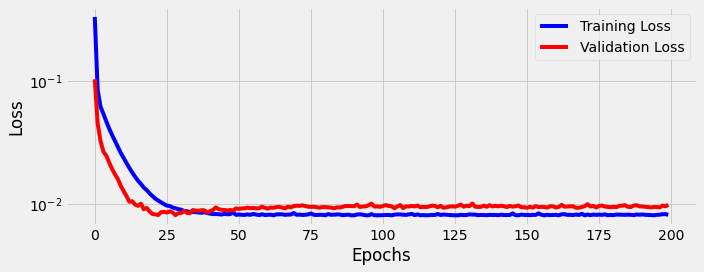

In [23]:
fig = sbs.plot_losses()

Predictions

In [30]:
new_data = np.array([.5, .3, .7]).reshape(-1, 1)

In [31]:
new_data

array([[0.5],
       [0.3],
       [0.7]])

In [32]:
predictions = sbs.predict(new_data)
predictions

array([[1.9891285],
       [1.5974443],
       [2.3808126]], dtype=float32)

Save model

In [33]:
sbs.save_checkpoint('model_checkpoint.pth')

Load model

In [35]:
%run -i model_configuration/v4.py

In [37]:
new_sbs = StepbyStep(model, loss_fn, optimizer)
new_sbs.load_checkpoint('model_checkpoint.pth')
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9584]])), ('0.bias', tensor([1.0099]))])


In [38]:
new_sbs.set_loaders(train_loader, val_loader)
new_sbs.train(n_epochs=50)

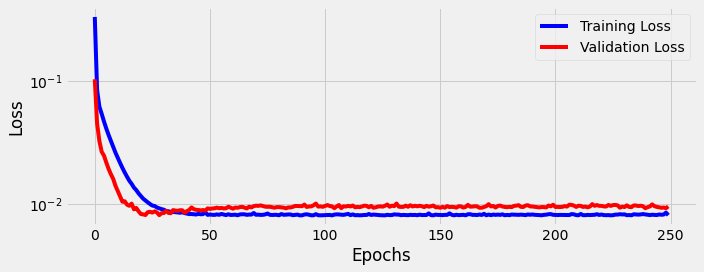

In [39]:
fig = new_sbs.plot_losses()